[![img](..\ep8_2018-57x57.png)](http://endlesspint.com/)

# Winners Take All - The Movies

**post @** [endlesspint.com](http://endlesspint.com/2019-11-08-winners-take-all-the-movies/)

In [4]:
import pymc3 as pm
import numpy as np
import pandas as pd
from theano import shared
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

plt.style.use('ggplot')

In [5]:
df_movies = pd.read_excel("rundown2.xlsx", sheet_name="list")
df_movies_2018 = df_movies[df_movies.year == 2018]
df_movies_2018.head()

,year,rank,title,studio,gross,theaters_max,opening,theaters_open,wide,close,opening_of_gross,year_total,take_of_year,prev_year_Q1_theaters_open,prev_year_Q3_theaters_open,prev_year_IQR_theaters_open,prev_year_IQR,top_23
0,2018,1,Black Panther,BV,700059566,4084.0,202003951,4020.0,2019-02-16,2019-08-09 00:00:00,0.288553,11443053554,0.061178,2696.25,3771.0,0.0,above,1
1,2018,2,Avengers: Infinity War,BV,678815482,4474.0,257698183,4474.0,2019-04-27,2019-09-13 00:00:00,0.379629,11443053554,0.059321,2696.25,3771.0,0.0,above,1
2,2018,3,Incredibles 2,BV,608581744,4410.0,182687905,4410.0,2019-06-15,2019-12-13 00:00:00,0.300186,11443053554,0.053184,2696.25,3771.0,0.0,above,1
3,2018,4,Jurassic World: Fallen Kingdom,Uni.,417719760,4485.0,148024610,4475.0,2019-06-22,2019-10-04 00:00:00,0.354363,11443053554,0.036504,2696.25,3771.0,0.0,above,1
4,2018,5,Aquaman,WB,335061807,4184.0,67873522,4125.0,2019-12-21,2019-04-04 00:00:00,0.202570,11443053554,0.029281,2696.25,3771.0,0.0,above,1


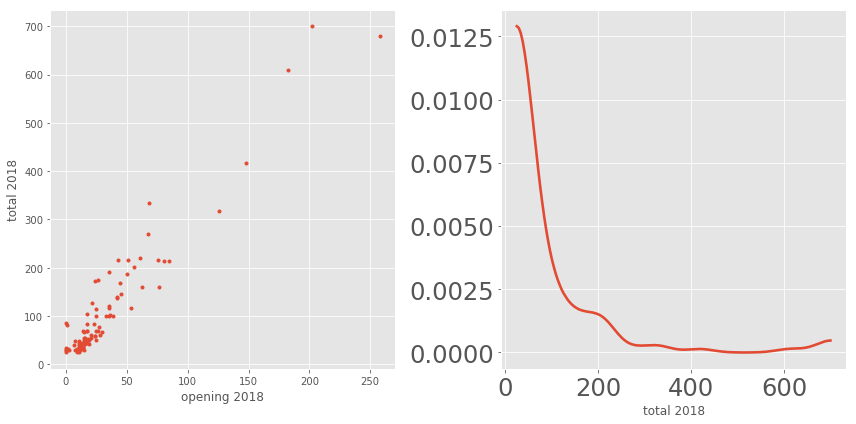

In [48]:
x = df_movies_2018.opening / 1e6
y = df_movies_2018.gross / 1e6

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('opening 2018')
ax[0].set_ylabel('total 2018', rotation=90)
# ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('total 2018')
plt.tight_layout()

In [7]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [05:54<00:00, 16.91draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001822BB0D358>,
      dtype=object)

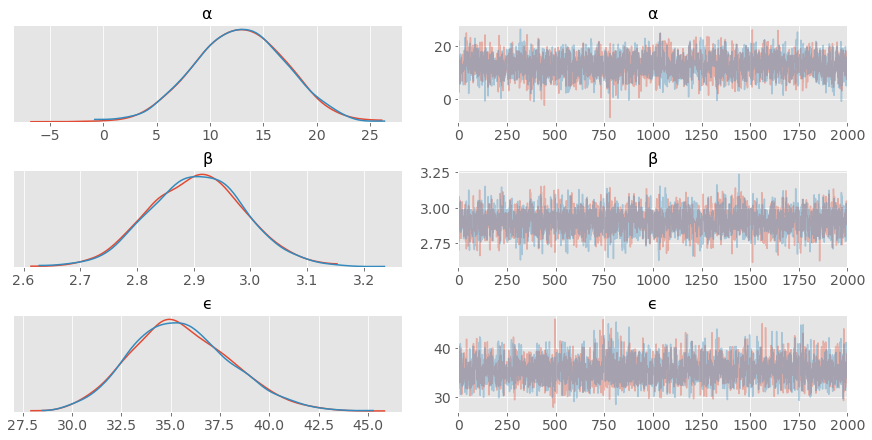

In [8]:
varnames=['α', 'β', 'ϵ']
az.plot_trace(trace_g, varnames)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001822AEBA048>,
      dtype=object)

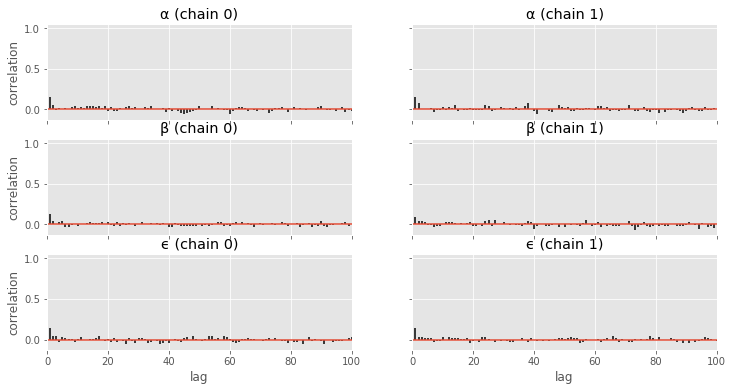

In [9]:
pm.autocorrplot(trace_g, varnames)

In [10]:
pm.summary(trace_g, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
α,12.729567,4.172058,0.088770,5.037160,20.911477,2720.990831,0.999754
β,2.904945,0.083367,0.001595,2.742058,3.067755,2796.117603,0.999836
ϵ,35.541795,2.569916,0.050670,30.855135,40.846955,2666.898836,0.999751


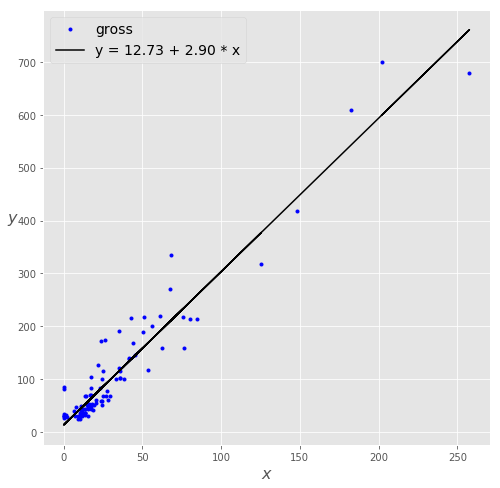

In [54]:
plt.figure(figsize=(8,8))
plt.plot(x, y, 'b.');
alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

In [12]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 724.01it/s]


In [13]:
idx = np.argsort(x)
x_ord = x[idx]

Text(0, 0.5, 'total 2018')

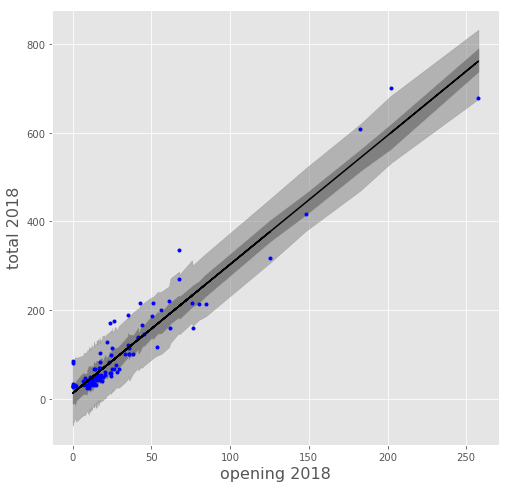

In [53]:
plt.figure(figsize=(8,8))
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('opening 2018', fontsize=16)
plt.ylabel('total 2018', fontsize=16, rotation=90)

## standardize

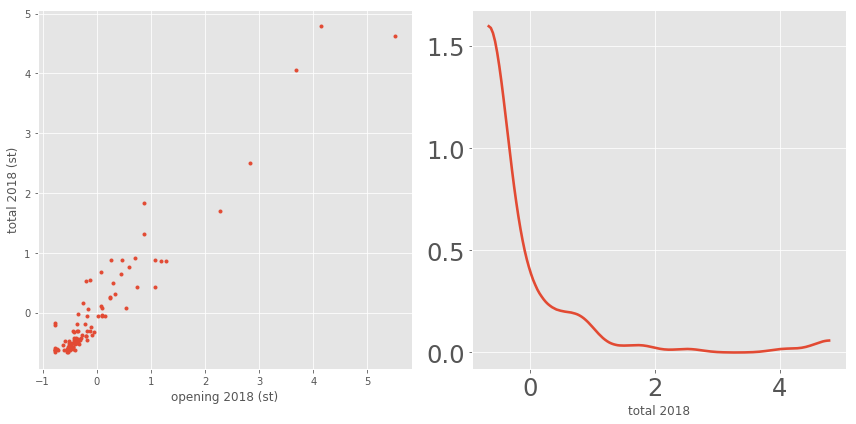

In [52]:
x_st = ( x - x.mean() ) / x.std()
y_st = ( y - y.mean() ) / y.std()

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x_st, y_st, 'C0.')
ax[0].set_xlabel('opening 2018 (st)')
ax[0].set_ylabel('total 2018 (st)', rotation=90)
# ax[0].plot(x, y_real, 'k')
az.plot_kde(y_st, ax=ax[1])
ax[1].set_xlabel('total 2018')
plt.tight_layout()

In [26]:
with pm.Model() as model_g_st:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x_st)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_st)

    trace_g_st = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [03:02<00:00, 32.82draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001822E00B630>,
      dtype=object)

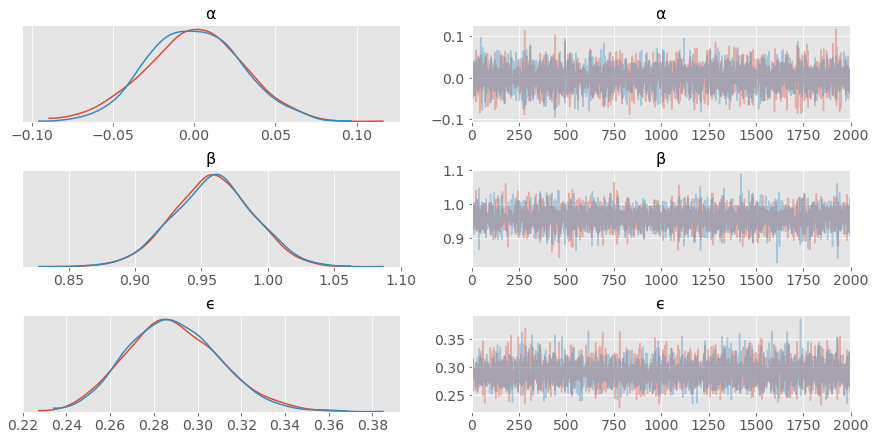

In [27]:
varnames=['α', 'β', 'ϵ']
az.plot_trace(trace_g_st, varnames)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001822DE39B38>,
      dtype=object)

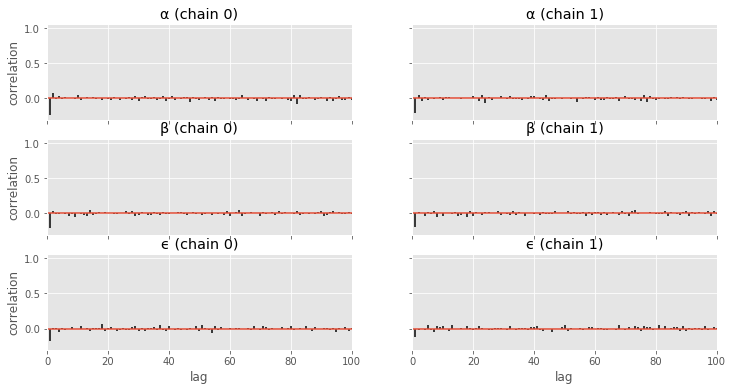

In [28]:
pm.autocorrplot(trace_g_st, varnames)

In [29]:
pm.summary(trace_g_st, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
α,-0.000343,0.029351,0.000388,-0.057351,0.057744,6008.910937,0.999751
β,0.958174,0.029923,0.000324,0.898988,1.014944,6398.802390,0.999852
ϵ,0.288903,0.021100,0.000288,0.247658,0.328762,5667.138043,0.999754


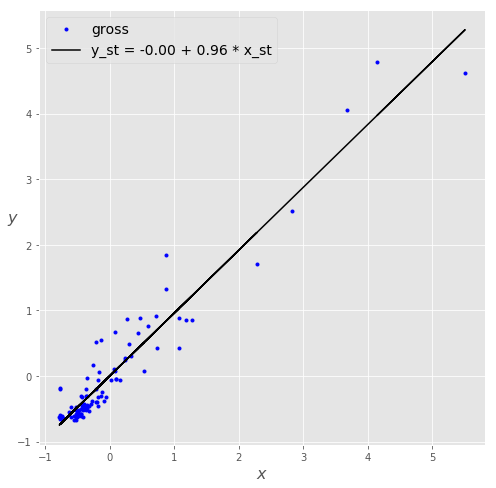

In [50]:
plt.figure(figsize=(8,8))
plt.plot(x_st, y_st, 'b.');
alpha_m_st = trace_g_st['α'].mean()
beta_m_st = trace_g_st['β'].mean()
plt.plot(x_st, alpha_m_st + beta_m_st * x_st, c='k', label='y_st = {:.2f} + {:.2f} * x_st'.format(alpha_m_st, beta_m_st))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

In [40]:
np.mean((y_hat, y_hat_dst), axis=0)

array([599.45059209, 760.9561736 , 543.4367262 , 442.91795765,
       210.49087119, 377.62044197, 209.61897841, 191.24452255,
       233.51195557, 161.73722425, 138.09445298, 258.47479038,
       246.39763982, 176.74840289, 116.21593739, 159.25042738,
        90.54277561,  81.88083301, 141.48199626, 193.93144759,
       234.69898504, 145.32712614, 134.3226809 , 134.77700807,
        76.46077653, 115.02352577, 169.700999  , 116.8287768 ,
        86.19526785,  64.44196249, 118.09581346, 117.34606287,
       109.7209224 , 125.48627101,  84.96053855,  14.59623046,
        63.2805185 ,  80.49618955,  15.19238987,  92.71034988,
        64.05004325,  62.98014501,  53.05362483,  90.82661409,
        85.88813477,  99.44887498,  55.72754109,  73.27760682,
        95.20109927,  82.20038619,  83.74802509,  72.68644387,
        57.0124148 ,  60.09871753,  65.53417808,  85.09725254,
        56.32719194,  68.7863471 ,  45.11698989,  60.15244907,
        36.19423372,  62.53962698,  64.7924224 ,  59.49

In [42]:
y_hat = alpha_m + beta_m * x
y_hat_dst = ((alpha_m_st + beta_m_st * x_st) * y.std()) + y.mean()

# mean absolute percentage diff bt standardized, non-standardized models
# not interested in identifying superior accuracy given ease of use of non-standardized model
np.mean(np.abs(y_hat - y_hat_dst) / np.mean((y_hat, y_hat_dst), axis=0))

0.03168624102777339

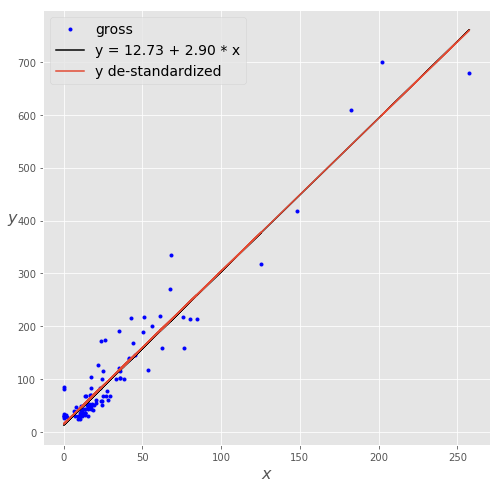

In [51]:
plt.figure(figsize=(8,8))
plt.plot(x, y, 'b.');

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.plot(x, y_hat_dst, label='y de-standardized')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

## need more robust, Student-t approach, or polynomial approach to capture/weigh clustered mass

In [13]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x, sd=epsilon, nu=nu, observed=y)

#     start = pm.find_MAP()
#     step = pm.NUTS(scaling=start) 
    trace_t = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, epsilon, beta, alpha]
Sampling 2 chains: 100%|████████████████████████████████████████████████████████| 6000/6000 [09:09<00:00, 10.92draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001BC22B1C198>,
      dtype=object)

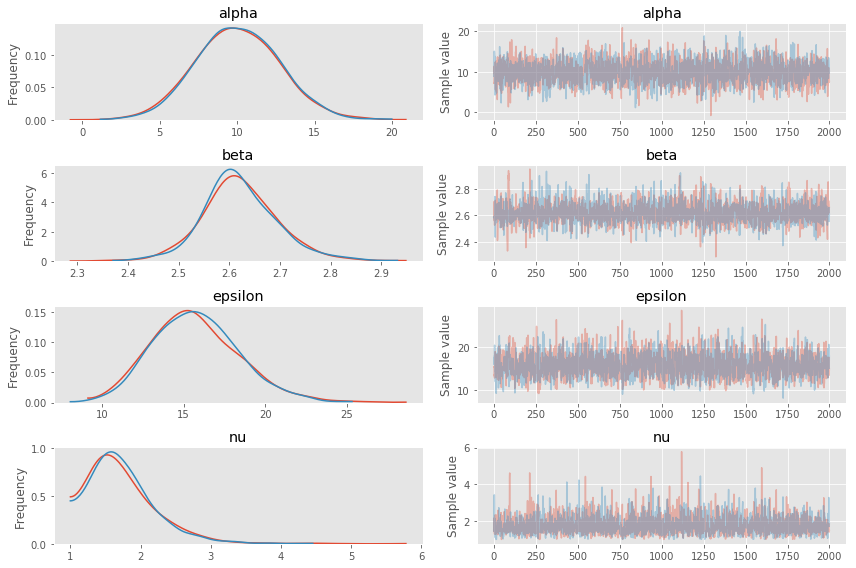

In [15]:
varnames_t = ['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_t, varnames_t)

In [17]:
pm.summary(trace_t, varnames_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,9.999708,2.658146,0.060879,5.083106,15.354958,2100.121507,1.000022
beta,2.620033,0.073872,0.001502,2.476216,2.774543,2385.146731,0.999750
epsilon,15.716498,2.644425,0.061735,10.747377,20.946899,2135.220818,0.999810
nu,1.748127,0.482303,0.010698,1.002571,2.657903,2263.597095,0.999767


In [18]:
df_movies_2017 = df_movies[df_movies.year == 2017]
df_movies_2017.head()

,year,rank,title,studio,gross,theaters_max,opening,theaters_open,wide,close,opening_of_gross,year_total,take_of_year,prev_year_Q1_theaters_open,prev_year_Q3_theaters_open,prev_year_IQR_theaters_open,prev_year_IQR,top_23
100,2017,1,Star Wars: The Last Jedi,BV,620181382,4232.0,220009584,4232.0,2019-12-15,2019-04-19 00:00:00,0.354750,10917015639,0.056809,2870.25,3775.75,0.0,above,1
101,2017,2,Beauty and the Beast (2017),BV,504014165,4210.0,174750616,4210.0,2019-03-17,2019-07-13 00:00:00,0.346718,10917015639,0.046168,2870.25,3775.75,0.0,above,1
102,2017,3,Wonder Woman,WB,412563408,4165.0,103251471,4165.0,2019-06-02,2019-11-09 00:00:00,0.250268,10917015639,0.037791,2870.25,3775.75,0.0,above,1
103,2017,4,Jumanji: Welcome to the Jungle,Sony,404515480,3849.0,36169328,3765.0,2019-12-20,2019-05-31 00:00:00,0.089414,10917015639,0.037054,2870.25,3775.75,1.0,inside,1
104,2017,5,Guardians of the Galaxy Vol. 2,BV,389813101,4347.0,146510104,4347.0,2019-05-05,2019-09-21 00:00:00,0.375847,10917015639,0.035707,2870.25,3775.75,0.0,above,1


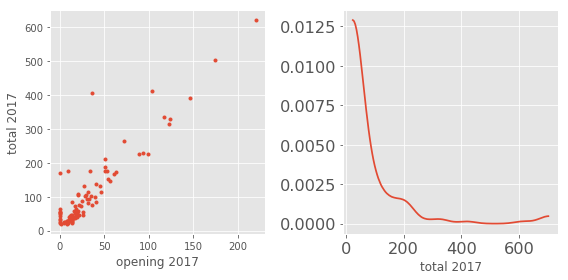

In [24]:
x_17 = df_movies_2017.opening / 1e6
y_17 = df_movies_2017.gross / 1e6

_, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(x_17, y_17, 'C0.')
ax[0].set_xlabel('opening 2017')
ax[0].set_ylabel('total 2017', rotation=90)
# ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('total 2017')
plt.tight_layout()

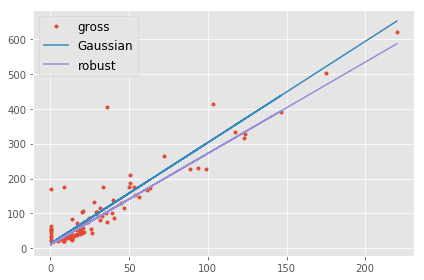

In [39]:
alpha_mt = trace_t['alpha'].mean()
beta_mt = trace_t['beta'].mean()

plt.figure(figsize=(8,8))
plt.plot(x_17, y_17, '.')
plt.plot(x_17, alpha_m + beta_m * x_17, label="Gaussian")
plt.plot(x_17, alpha_mt + beta_mt * x_17, label='robust')

plt.legend(loc=2, fontsize=12)
plt.tight_layout()

In [54]:
def rmse(y_s, y_hat):
    return np.sqrt(np.mean(np.square(y_s - y_hat)))
    
rmse(y_17, alpha_m + beta_m * x_17), rmse(y_17, alpha_mt + beta_mt * x_17)

(45.115778410027026, 45.68096376701758)

In [71]:
df_movies.pivot_table('year_total', 'year').sort_index(ascending=False).head(12)

,year_total
year,
2018,11443053554
2017,10917015639
2016,11020669954
2015,11056139869
2014,9962444806
2013,10639099916
2012,10684309637
2011,9720900574
2010,9965289688


In [80]:
not_training = df_movies.year != 2018
ten_bill_plus = df_movies.year >= 2009

df_movies_test = df_movies[not_training & ten_bill_plus]
df_movies_test.describe()

,year,rank,gross,theaters_max,opening,theaters_open,opening_of_gross,year_total,take_of_year,prev_year_Q1_theaters_open,prev_year_Q3_theaters_open,prev_year_IQR_theaters_open,top_23
count,900.000000,900.00000,9.000000e+02,900.000000,9.000000e+02,900.000000,900.000000,9.000000e+02,900.000000,900.000000,900.000000,900.000000,900.000000
mean,2013.000000,50.50000,9.880337e+07,3141.438889,2.965413e+07,2928.901111,0.306564,1.052726e+10,0.009384,2692.250000,3535.527778,0.487778,0.230000
std,2.583425,28.88212,9.599552e+07,678.147361,3.156643e+07,1046.991487,0.121435,4.787958e+08,0.008982,144.901054,124.706744,0.500129,0.421066
min,2009.000000,1.00000,2.078370e+07,776.000000,3.161000e+04,1.000000,0.000607,9.720901e+09,0.001904,2368.000000,3333.500000,0.000000,0.000000
25%,2011.000000,25.75000,4.023636e+07,2807.750000,1.237883e+07,2718.000000,0.256189,9.965290e+09,0.003863,2686.500000,3470.000000,0.000000,0.000000
50%,2013.000000,50.50000,6.420930e+07,3171.000000,1.985234e+07,3115.500000,0.320339,1.068431e+10,0.006075,2727.000000,3506.500000,0.000000,0.000000
75%,2015.000000,75.25000,1.175849e+08,3602.250000,3.426934e+07,3558.750000,0.380311,1.091702e+10,0.011282,2769.750000,3559.500000,1.000000,0.000000
max,2017.000000,100.00000,9.366622e+08,4535.000000,2.479667e+08,4529.000000,0.633332,1.105614e+10,0.084719,2870.250000,3775.750000,1.000000,1.000000


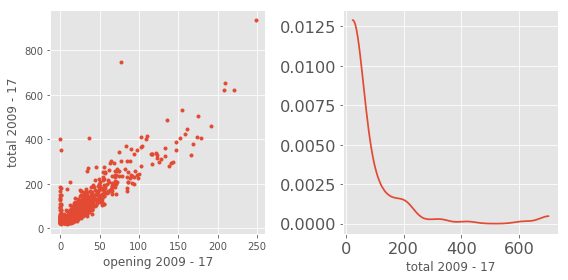

In [81]:
x_test = df_movies_test.opening / 1e6
y_test = df_movies_test.gross / 1e6

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x_test, y_test, 'C0.')
ax[0].set_xlabel('opening 2009 - 17')
ax[0].set_ylabel('total 2009 - 17', rotation=90)
# ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('total 2009 - 17')
plt.tight_layout()

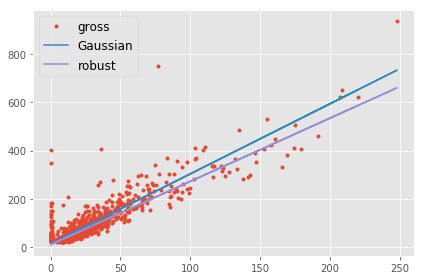

In [82]:
plt.plot(x_test, y_test, '.')
plt.plot(x_test, alpha_m + beta_m * x_test, label="Gaussian")
plt.plot(x_test, alpha_mt + beta_mt * x_test, label='robust')

plt.legend(loc=2, fontsize=12)
plt.tight_layout()

In [83]:
rmse(y_test, alpha_m + beta_m * x_test), rmse(y_test, alpha_mt + beta_mt * x_test)

(44.557219486395766, 45.5443973651019)

In [85]:
df_movies_2019 = pd.read_excel("../../20190520_wta_movies/rundown2.xlsx", sheet_name="2019_YTD (Oct 16)")
df_movies_2019 = df_movies_2019[df_movies_2019.year == 2019]
print(df_movies_2019.shape)
df_movies_2019.head()

(100, 10)


,year,rank,title,studio,gross,theaters_max,opening,theaters_open,wide,close
0,2019.0,1,Avengers: Endgame,BV,858373000.0,4662,357115007,4662,2019-04-26 00:00:00,2019-09-12 00:00:00
1,2019.0,2,The Lion King (2019),BV,542461804.0,4802,191770759,4725,2019-07-19 00:00:00,-
2,2019.0,3,Toy Story 4,BV,433586786.0,4575,120908065,4575,2019-06-21 00:00:00,-
3,2019.0,4,Captain Marvel,BV,426829839.0,4310,153433423,4310,2019-03-08 00:00:00,2019-07-04 00:00:00
4,2019.0,5,Spider-Man: Far from Home,Sony,390470129.0,4634,92579212,4634,2019-07-02 00:00:00,-


In [90]:
df_movies_2019_closed = df_movies_2019[df_movies_2019.close != "-"]
print(df_movies_2019_closed.shape)
df_movies_2019_closed.head(10)

(70, 10)


,year,rank,title,studio,gross,theaters_max,opening,theaters_open,wide,close
0,2019.0,1,Avengers: Endgame,BV,858373000.0,4662,357115007,4662,2019-04-26 00:00:00,2019-09-12 00:00:00
3,2019.0,4,Captain Marvel,BV,426829839.0,4310,153433423,4310,2019-03-08 00:00:00,2019-07-04 00:00:00
8,2019.0,9,Us,Uni.,175005930.0,3743,71117625,3741,2019-03-22 00:00:00,2019-06-06 00:00:00
10,2019.0,11,John Wick: Chapter 3 - Parabellum,LG/S,171015687.0,3850,56818067,3850,2019-05-17 00:00:00,2019-09-12 00:00:00
11,2019.0,12,How to Train Your Dragon: The Hidden World,Uni.,160799505.0,4286,55022245,4259,2019-02-22 00:00:00,2019-06-13 00:00:00
12,2019.0,13,The Secret Life of Pets 2,Uni.,158257265.0,4564,46652680,4561,2019-06-07 00:00:00,2019-09-19 00:00:00
13,2019.0,14,Pokemon Detective Pikachu,WB,144105346.0,4248,54365242,4202,2019-05-10 00:00:00,2019-08-15 00:00:00
14,2019.0,15,Shazam!,WB (NL),140371656.0,4306,53505326,4217,2019-04-05 00:00:00,2019-07-25 00:00:00
16,2019.0,17,Dumbo (2019),BV,114766307.0,4259,45990748,4259,2019-03-29 00:00:00,2019-08-08 00:00:00
17,2019.0,18,Glass,Uni.,111035005.0,3844,40328920,3841,2019-01-18 00:00:00,2019-04-04 00:00:00


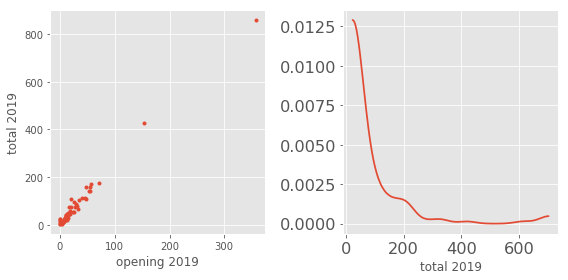

In [91]:
x_19 = df_movies_2019_closed.opening / 1e6
y_19 = df_movies_2019_closed.gross / 1e6

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x_19, y_19, 'C0.')
ax[0].set_xlabel('opening 2019')
ax[0].set_ylabel('total 2019', rotation=90)
# ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('total 2019')
plt.tight_layout()

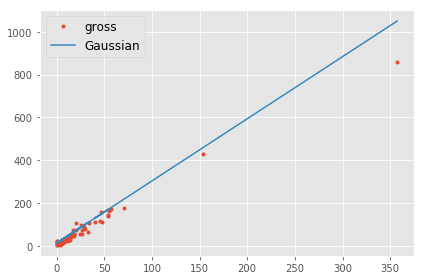

In [92]:
plt.figure(figsize=(8,8))
plt.plot(x_19, y_19, '.')
plt.plot(x_19, alpha_m + beta_m * x_19, label="Gaussian")

plt.legend(loc=2, fontsize=12)
plt.tight_layout()

In [99]:
jw3_opening = df_movies_2019_closed.loc[10, 'opening']

alpha_m + beta_m * jw3_opening

164981834.87753886

In [100]:
jw3_total = df_movies_2019_closed.loc[10, 'gross']
jw3_total

171015687.0